# imports and static stuff

In [1]:
%cd src

/home/evry/Desktop/master-degree/repositories/vision-anomaly/src


/home/evry/anaconda3/envs/vision-anomaly/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


#### Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torchvision
from torchvision import transforms
import cv2

from torchsummary import summary
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.optim import Adam

from model.model import Model

from src.data_loader.data_loader import MVTec
from progressbar import Bar, DynamicMessage, ProgressBar, ETA

from torchmetrics.image import StructuralSimilarityIndexMeasure
from torch.utils.data import random_split

from sklearn.metrics import roc_auc_score

import matplotlib.cm as cm
from PIL import Image


In [3]:
print(torch.__version__)

2.3.0


#### Plotting data

In [4]:
import os

def save_comparison(class_name: str, file_name:str, image, mask, reconstruction, ssim_map, save_fig: bool, plot: bool, path: str = "../runs"):
    with torch.no_grad():
        _input_image = image.cpu().numpy()[0].transpose(1, 2, 0)
        _mask = mask.cpu().numpy()[0].transpose(1, 2, 0)
        _ssim_map = ssim_map.cpu().numpy()[0][0]

        # Normalize the SSIM map
        ssim_map_norm = (_ssim_map - _ssim_map.min()) / (_ssim_map.max() - _ssim_map.min())
        
        # Create a heatmap from the normalized SSIM map
        heatmap = cv2.applyColorMap((ssim_map_norm * 255).astype(np.uint8), cv2.COLORMAP_JET)

        # Convert _input_image to uint8
        _input_image_uint8 = (_input_image * 255).astype(np.uint8)

        # Overlay the heatmap on the original input image
        overlay = cv2.addWeighted(_input_image_uint8, 0.4, heatmap, 0.6, 0)

        # Plot the results

        fig = plt.figure(figsize=(10, 3))

        ax1 = fig.add_subplot(141)
        ax1.imshow(_input_image, cmap='gray')
        ax1.set_title('Input')
        
        reconstruction_norm = (reconstruction - reconstruction.min()) / (reconstruction.max() - reconstruction.min())
        
        ax2 = fig.add_subplot(142)
        ax2.imshow(reconstruction_norm.cpu().numpy()[0].transpose(1, 2, 0))
        ax2.set_title('Reconstructed')
        
        ax3 = fig.add_subplot(143)
        ax3.imshow(_mask, cmap='gray')
        ax3.set_title('GT')
        
        ax4 = fig.add_subplot(144)
        ax4.imshow(overlay)
        ax4.set_title('Pred')
        
        plt.tight_layout()
        # if plot:
        #     plt.show()
        
        path += f"/{class_name}/plots/"
        
        if not os.path.exists(path):
            os.makedirs(path)
        
        if save_fig:
            fig.savefig(path + file_name)        
        
        fig.clear()
        plt.close()
        plt.cla()
        plt.clf()

#### Loading data

In [5]:
dataset_root_path = "/home/evry/Desktop/master-degree/repositories/two-stage-coarse-to-fine-image-anomaly-segmentation-and-detection-model/data/images"
# dataset_root_path = "/home/evry/Desktop/master-degree/dataset/BTech_Dataset_transformed"

def read_data(class_name: str, batch_size=32, file_extension: str = "png"):
    train_dataset = MVTec(class_name=class_name, root_dir=dataset_root_path + f"/{class_name}", test=False, resize_shape=[256, 256], file_extension=file_extension)
    test_dataset = MVTec(class_name=class_name,root_dir=dataset_root_path + f"/{class_name}", test=True, resize_shape=[256, 256], file_extension=file_extension)

    train_loader = DataLoader(dataset = train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset = test_dataset, batch_size=1, shuffle=True)
    
    return train_loader, test_loader

# Reconstruction approach

- [ ] Test model after each epoch (remember to put model in train mode)
- [ ] Perform early stopping based on the model test

In [6]:
def test_reconstruction(class_name: str, epoch: int, model: Model, test_loader: DataLoader, plot: bool = False, save_fig: bool = True):
    mse_sum = 0
    ssim_sum = 0
    loss_sum = 0

    anomaly_samples_saved = 0
    
    SSIM = StructuralSimilarityIndexMeasure(return_full_image=True).cpu()
    
    model.eval()
    
    ssim_maps_list = []
    ground_truth_list = []
    
    for i, (input_batch, mask_batch, has_anomaly_batch, _) in enumerate(test_loader):
        _, reconstruction = model(input_batch.cuda())
        
        mse = F.mse_loss(reconstruction.cpu(), input_batch.cpu(), reduction='mean')
            
        mse_sum += mse.item()
        
        ssim_value, ssim_map = SSIM(input_batch.cpu(), reconstruction.cpu())
        
        ssim_sum += ssim_value.item()
        
        loss_sum += mse.item() + (1.0 - ssim_value.item())
        
        if has_anomaly_batch[0] and anomaly_samples_saved < 1:
            save_comparison(
                class_name,
                f"anomaly_sample_epoch_{epoch}.jpg",
                input_batch,
                mask_batch,
                reconstruction,
                ssim_map,
                save_fig,
                plot,
                path="../runs/reconstruction"
            )
            
            anomaly_samples_saved += 1
            
        if has_anomaly_batch[0]:
            anomaly_score_map = 1 - ssim_map.cpu().detach().numpy()
            ssim_maps_list.append(anomaly_score_map.flatten())
            
            binary_ground_truth = (mask_batch.cpu().detach().numpy() > 0).astype(int)
            ground_truth_list.append(binary_ground_truth.flatten())
            
    model.train()
    
    del input_batch
    del mask_batch
    del has_anomaly_batch
    
    # Flatten the lists of arrays
    ssim_maps_array = np.concatenate(ssim_maps_list)
    ground_truth_array = np.concatenate(ground_truth_list)
    
    # Calculate the ROC-AUC
    auc_score = roc_auc_score(ground_truth_array, ssim_maps_array)
    
    batches = test_loader.__len__()
    
    return mse_sum / batches, ssim_sum / batches, loss_sum / batches, auc_score

In [7]:
def train_reconstruction(class_name: str, batch_size=32, epochs=400, model_depth=16, model_patch_size=32):
    print(f"\n\nStart training for object \"{class_name}\"\n\n\n")
    
    progressbar_widgets = [
        DynamicMessage('log', format = '{formatted_value}'),
        Bar(marker='=', left='[', right=']'),
        ' ',  ETA(),
    ]

    SSIM = StructuralSimilarityIndexMeasure().cpu()
    
    best_epoch = -1
    best_loss = 1e10
    
    train_loader, test_loader = read_data(class_name, batch_size=batch_size)
    
    model = Model(patch_size=model_patch_size, depth=model_depth).cuda()
    model.train()

    # print(summary(model, (3, 256, 256)))
    
    summary_writer = SummaryWriter(log_dir=f'../runs/reconstruction/{class_name}')

    optimizer = Adam(list(model.parameters()), lr=0.0001, weight_decay=0.0001)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer,[epochs*0.2, epochs*0.5, epochs*0.7],gamma=0.1, last_epoch=-1)

    for epoch in range(epochs):
        train_mse_sum = 0.0
        train_ssim_sum = 0.0
        train_loss_sum = 0.0
        
        with ProgressBar(widgets=progressbar_widgets, max_value=train_loader.__len__() + 1) as progress_bar:
            for sample_i, (input_batch, mask_batch, _, _) in enumerate(train_loader):
                model.zero_grad()
                
                _, reconstruction = model(input_batch.cuda())
                
                mse = F.mse_loss(reconstruction.cpu(), input_batch.cpu(), reduction='mean')
                
                train_mse_sum += mse.cpu().item()
                
                ssim_value = SSIM(input_batch.cpu(), reconstruction.cpu())
                
                train_ssim_sum += ssim_value.cpu().item()
                
                loss = mse.cpu().item() + (1.0 - ssim_value.cpu().item())
                
                train_loss_sum += loss

                mse.backward()
                
                optimizer.step()                
                
                progress_bar.update(
                                sample_i,
                                log=f"({epoch+1}/{epochs}) MSE: {mse:.4f} SSIM: {ssim_value:.4f} Loss: {loss:.4f}")

            batches = train_loader.__len__()
            
            train_mse = train_mse_sum / batches
            train_ssim = train_ssim_sum / batches
            train_loss = train_loss_sum / batches
            
            summary_writer.add_scalar('train_mse', train_mse, epoch)
            summary_writer.add_scalar('train_ssim', train_ssim, epoch)
            summary_writer.add_scalar('train_loss', train_loss, epoch)
            
            log = f"({epoch+1}/{epochs}) MSE: {train_mse:.4f} SSIM: {train_ssim:.4f} Loss: {train_loss:.4f}"
            
            del input_batch
            del mask_batch
            
            test_mse, test_ssim, test_loss, test_auc_score = test_reconstruction(class_name, epoch, model, test_loader, save_fig=epoch % 5 == 0)
            
            summary_writer.add_scalar('test_mse', test_mse, epoch)
            summary_writer.add_scalar('test_ssim', test_ssim, epoch)
            summary_writer.add_scalar('test_loss', test_loss, epoch)
            summary_writer.add_scalar('test_auc', test_auc_score, epoch)
            
            log += f" | Test MSE: {test_mse:.4f} Test SSIM: {test_ssim:.4f} Test AUC: {test_auc_score:.4f} Test Loss: {test_loss:.4f} Best loss: {best_loss:.4f} ({best_epoch})"      
                    
            progress_bar.update(batches, log=log)

        scheduler.step()

        if test_loss < best_loss and best_loss - test_loss >= 0.01:
            best_epoch = epoch
            best_loss = test_loss
            
            torch.save(model.state_dict(), f'../vit_models/reconstruction/vit_{class_name}.pt')
        elif epoch - best_epoch >= 50:
            print("\n\n==========================================================================================")
            print(f"Stopping training for object {class_name}. No improvements since epoch {best_epoch}")
            print("==========================================================================================")
            
            break
        
    del model
    del optimizer

In [8]:
model_depth = 8
model_patch_size = 8

In [9]:
# classes = ['01', '02', '03']
classes = ['bottle','cable','capsule','carpet','grid','hazelnut','leather','metal_nut','pill','screw','tile','toothbrush','transistor','wood','zipper']
# classes = ['bottle']

for class_name in classes:
    train_reconstruction(class_name, batch_size=4, epochs=200, model_depth=model_depth, model_patch_size=model_patch_size)



Start training for object "bottle"





OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 GiB. GPU 

### Loading saved model and testing it

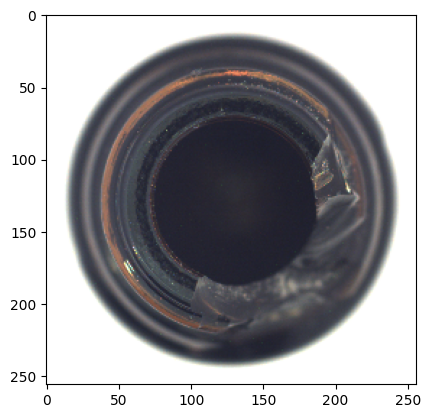

In [7]:
class_name = "bottle"

model = Model(patch_size=model_patch_size, depth=model_depth).cuda()

model.load_state_dict(torch.load(f'../vit_models/reconstruction/vit_{class_name}.pt'))

model.eval()

_, test_loader = read_data(class_name)

test_image, mask, has_anomaly, _ = test_loader.dataset.__getitem__(0)

test_image = test_image.unsqueeze(0).cuda()

plt.imshow(test_image.cpu().numpy()[0].transpose(1, 2, 0))

In [18]:
# # mask = model.mask

# output = model.vit.transformer(test_image.cuda()[0])

# with torch.no_grad():
#     plt.imshow(output.cpu().numpy().transpose(1, 2, 0))

In [89]:
SSIM = StructuralSimilarityIndexMeasure(return_full_image=True).cpu()

encoded, reconstruction = model(test_image)

loss = F.mse_loss(reconstruction, test_image, reduction='mean')
ssim_value, ssim_map = SSIM(reconstruction.cpu(), test_image.cpu())

loss.item(), ssim_value.item()

(0.0033386610448360443, 0.7797465920448303)

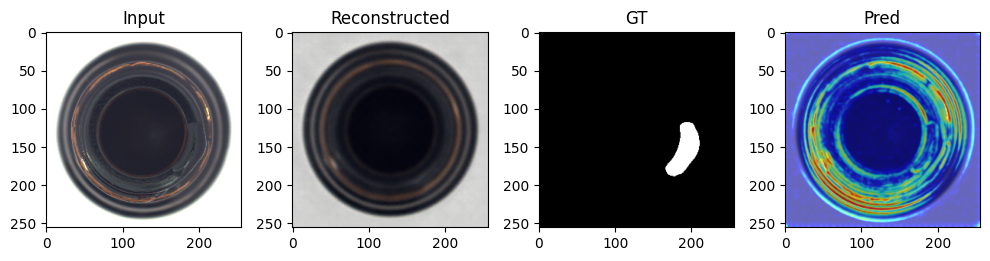

(0.00392686887728387,
 0.7729402170123825,
 0.23098665186490144,
 0.7988484355626051)

<Figure size 640x480 with 0 Axes>

In [97]:
test_reconstruction(class_name, -1, model, test_loader, save_fig=False, plot=True)

In [ ]:
ssim_map.cpu().detach().numpy()[0].transpose(1, 2, 0)

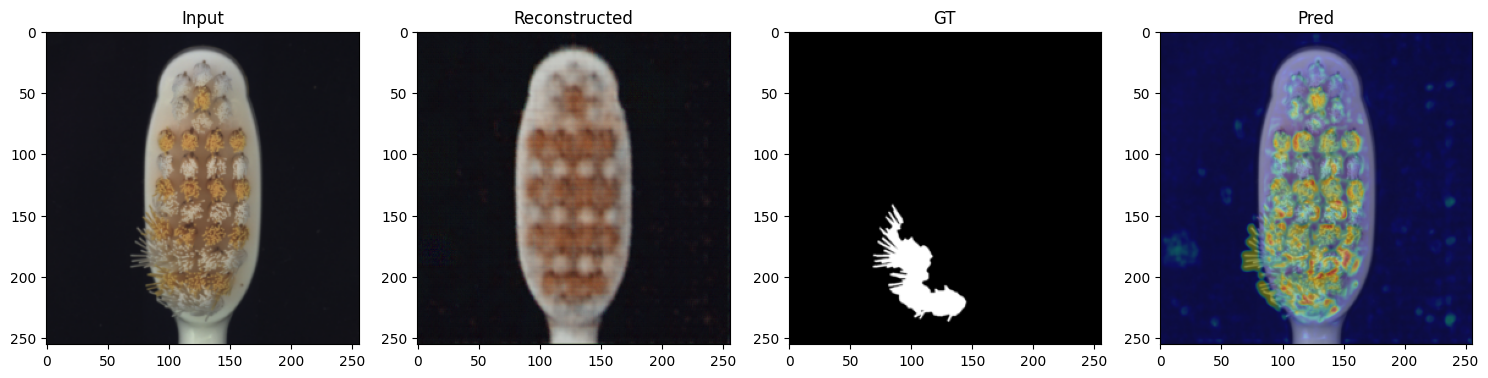

# Classification approach

In [26]:
def test_classification(class_name: str, epoch: int, model: Model, test_loader: DataLoader, plot: bool = False, save_fig: bool = True):
    loss_sum = 0.0
    accuracy_sum = 0.0

    # samples_saved = 0
    
    model.eval()
    
    crossEntropyLoss = nn.CrossEntropyLoss()
    
    for i, (input_batch, mask_batch, _, y_true) in enumerate(test_loader):
        y_pred = model(input_batch.cuda())
        
        loss = crossEntropyLoss(y_pred.cpu(), y_true.cpu())
            
        loss_sum += loss.cpu().item()
        
        with torch.no_grad():
            # Convert softmax output to predicted classes
            predicted_classes = np.argmax(y_pred.cpu(), axis=1).cpu().numpy()
            # print(f"Pred: {predicted_classes}")
            # Convert one-hot encoded true labels to class indices
            true_classes = np.argmax(y_true.cpu(), axis=1).cpu().numpy()
            # print(f"True: {true_classes}")

            # Calculate accuracy
            accuracy = np.mean(predicted_classes == true_classes)
            
            accuracy_sum += accuracy 
        
        # if samples_saved < 1:
        #     save_comparison(
        #         class_name,
        #         f"anomaly_sample_epoch_{epoch}.jpg",
        #         input_batch,
        #         mask_batch,
        #         reconstruction,
        #         ssim_map,
        #         save_fig,
        #         plot,
        #         path="../runs/classification"
        #     )
            
        #     samples_saved += 1
            
    model.train()
    
    # TODO: Add accuracy, precision, f1, other metrics..
    
    batches = test_loader.__len__()
    
    return loss_sum / batches, accuracy_sum / batches

In [27]:
def train_classification(class_name: str, model_depth=16, model_patch_size=32):
    print(f"\n\nStart classification training for object \"{class_name}\"\n\n\n")
    
    progressbar_widgets = [
        DynamicMessage('log', format = '{formatted_value}'),
        Bar(marker='=', left='[', right=']'),
        ' ',  ETA(),
    ]
    
    best_epoch = -1
    best_loss = 1e10
    epochs = 50
    
    train_loader, test_loader = read_data(class_name)
    
    model = Model(patch_size=model_patch_size, depth=model_depth, reconstruction=False, num_classes=2).cuda()
    model.train()

    # print(summary(model, (3, 256, 256)))
    
    summary_writer = SummaryWriter(log_dir=f'../runs/classification/{class_name}')

    optimizer = Adam(list(model.parameters()), lr=0.0001, weight_decay=0.0001)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer,[epochs*0.4, epochs*0.7],gamma=0.1, last_epoch=-1)

    crossEntropyLoss = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        loss_sum = 0.0
        accuracy_sum = 0.0
        
        with ProgressBar(widgets=progressbar_widgets, max_value=test_loader.__len__() + 1) as progress_bar:
            for sample_i, (input_batch, mask_batch, _, y_true) in enumerate(test_loader):
                model.zero_grad()
                
                input_batch = input_batch.cuda()
                
                y_pred = model(input_batch)
                
                y_pred = y_pred.cpu()
                
                loss = crossEntropyLoss(y_pred, y_true.cpu())
            
                loss_sum += loss.cpu().item()

                loss.backward()
                
                optimizer.step()
                
                with torch.no_grad():
                    # Convert softmax output to predicted classes
                    predicted_classes = np.argmax(y_pred, axis=1).cpu().numpy()
                    # print(f"Pred: {predicted_classes}")
                    # Convert one-hot encoded true labels to class indices
                    true_classes = np.argmax(y_true, axis=1).cpu().numpy()
                    # print(f"True: {true_classes}")

                    # Calculate accuracy
                    accuracy = np.mean(predicted_classes == true_classes)
                    
                    accuracy_sum += accuracy.item()
                
                progress_bar.update(
                                sample_i,
                                log=f"({epoch+1}/{epochs}) Loss: {loss:.4f} Accuracy: {accuracy:.4f}")

            batches = test_loader.__len__()
            
            train_loss = loss_sum / batches
            train_accuracy = accuracy_sum / batches

            summary_writer.add_scalar('train_loss', train_loss, epoch)
            summary_writer.add_scalar('train_accuracy', train_accuracy, epoch)
            
            log = f"({epoch+1}/{epochs}) Loss: {train_loss:.4f} Accuracy: {train_accuracy}"
            
            # test_loss, test_accuracy = test_classification(class_name, epoch, model, test_loader, save_fig=epoch % 5 == 0)
            
            # summary_writer.add_scalar('test_loss', test_loss, epoch)
            # summary_writer.add_scalar('test_accuracy', test_accuracy, epoch)
            
            # log += f" | Test loss: {test_loss:.4f} Test accuracy: {test_accuracy:.4f} Best loss: {best_loss:.4f} ({best_epoch})"
                    
            progress_bar.update(batches, log=log)

        scheduler.step()

        # TODO trocar para test loss
        if train_loss < best_loss and best_loss - train_loss >= 0.01:
            best_epoch = epoch
            best_loss = train_loss
            
            torch.save(model.state_dict(), f'../vit_models/classification/vit_{class_name}.pt')
        elif epoch - best_epoch >= 50:
            print("\n\n==========================================================================================")
            print(f"Stopping training for object {class_name}. No improvements since epoch {best_epoch}")
            print("==========================================================================================")
            
            break
        
    del model
    del optimizer
                

In [6]:
model_depth = 32
model_patch_size = 16

In [ ]:
# classes = ['01', '02', '03']
# classes = ['bottle','cable','capsule','carpet','grid','hazelnut','leather','metal_nut','pill','screw','tile','toothbrush','transistor','wood','zipper']
classes = ['zipper']

for class_name in classes:
    train_classification(class_name, model_depth=model_depth, model_patch_size=model_patch_size)

### Interpretability

In [7]:
model = Model(patch_size=model_patch_size, depth=model_depth, reconstruction=False, num_classes=2).cuda()
model.load_state_dict(torch.load("../vit_models/classification/vit_zipper.pt"))
model.eval()

Model(
  (vit): ViT(
    (to_patch_embedding): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=16, p2=16)
      (1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (2): Linear(in_features=768, out_features=256, bias=True)
      (3): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (dropout): Dropout(p=0.0, inplace=False)
    (transformer): Transformer(
      (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (layers): ModuleList(
        (0-31): 32 x ModuleList(
          (0): Attention(
            (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (attend): Softmax(dim=-1)
            (dropout): Dropout(p=0.0, inplace=False)
            (to_qkv): Linear(in_features=256, out_features=1536, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=512, out_features=256, bias=True)
              (1): Dropout(p=0.0, inplace=False)
            )
          )
         

In [18]:
class_names = ['normal', 'anomaly']

def generate_heatmap(model, img):
    img_tensor = img.unsqueeze(0)  # Shape (1, 3, 256, 256)
    print(f"Img shape: {img_tensor.shape}")

    img_tensor.requires_grad = True

    # Get model predictions
    model.eval()
    preds = model(img_tensor)
    score = F.softmax(preds[0], dim=0)
    proba = 100 * torch.max(score).item()

    model_preds = torch.round(preds)
    top_pred_index = torch.argmax(score).item()

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_tensor, model, 'transformer.norm', pred_index=top_pred_index)
    
    # Remove the class token (first token)
    heatmap = heatmap[1:]
    
    # Reshape heatmap to match the input size, or the output size of the feature map
    heatmap = heatmap.reshape((16, 16))
    
    return heatmap, class_names[top_pred_index], proba

def make_gradcam_heatmap(img_tensor, model, last_layer_name, pred_index=None):
    # Set model to evaluation mode
    model.eval()

    # Hook for the gradients of the activations
    gradients = []
    def save_gradient(grad):
        gradients.append(grad)

    # Hook for the forward pass activations
    activations = []

    def hook_fn(module, input, output):
        activations.append(output)
        output.register_hook(save_gradient)

    img_tensor.requires_grad = True

    # Register the forward hook and the backward hook
    last_layer = model.vit.transformer.norm
    hook = last_layer.register_forward_hook(hook_fn)

    # Forward pass
    output = model(img_tensor)
    predictions = F.softmax(output, dim=1)
    pred_index = torch.argmax(predictions) if pred_index is None else pred_index

    print(f"Output shape: {output.shape}")
    print(f"Predictions shape: {predictions.shape}")
    print(f"Predicted class index: {pred_index}")

    # Backward pass
    model.zero_grad()
    class_channel = output[:, pred_index]
    class_channel.backward()

    # Get the gradients and the activations
    grads_val = gradients[0]
    activations_val = activations[0]

    print(f"Gradients shape: {grads_val.shape}")
    print(f"Activations shape: {activations_val.shape}")

    # Pool the gradients across the sequence length
    pooled_grads = torch.mean(grads_val, dim=1)
    print(f"Pooled grads shape: {pooled_grads.shape}")

    # Weight the channels by corresponding gradients
    activations_weighted = activations_val * pooled_grads.unsqueeze(1)

    # Create the heatmap by averaging over the embedding dimension
    heatmap = torch.mean(activations_weighted, dim=-1).squeeze()

    # Normalize the heatmap between 0 and 1 for visualization purposes
    heatmap = torch.maximum(heatmap, torch.tensor(0.0))
    heatmap /= torch.max(heatmap)

    # Remove hooks
    hook.remove()

    return heatmap.cpu().detach().numpy()

def save_and_display_gradcam(img, heatmap, alpha=1, pred=None):
    # Load the original image
    # img = Image.open(img_path)
    img = np.array(img)
    print(f"Image shape: {img.shape}")
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    if pred == 'malignant':
        # cm.ColormapRegistry.get_cmap
        jet = plt.get_cmap("jet")
    else:
        jet = plt.get_cmap("Greens")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    print(f"Jet colors: {jet_colors.shape}")
    jet_heatmap = jet_colors[heatmap]
    print(f"Jet jet_heatmap: {jet_heatmap.shape}")
     
    # Create an image with RGB colorized heatmap
    jet_heatmap = Image.fromarray((jet_heatmap * 255).astype(np.uint8))
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[2]))
    jet_heatmap = np.array(jet_heatmap)
    print(f"Jet jet_heatmap2: {jet_heatmap.shape}")

    # Superimpose the heatmap on original image
    superimposed_img = (jet_heatmap * alpha) + img.transpose(1, 2, 0) * 255
    superimposed_img = Image.fromarray(superimposed_img.astype(np.uint8))

    # Otsu's thresholding
    jet_heatmap_gray = cv2.cvtColor(jet_heatmap, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(jet_heatmap_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Display the superimposed image
    plt.imshow(superimposed_img)
    plt.show()

    return thresh


In [9]:
_train_loader, _test_loader = read_data('zipper')

In [24]:
# image1 = dataset_root_path + "/zipper/test/broken_teeth/001.png"
# # Load images
# img = Image.open(PATH1)
# img_orig = Image.open(IMG1)

# model.vit.transformer.layers[-1][0]

image, mask, has_anomaly, _ =_test_loader.dataset.__getitem__(2)

# Generate heatmap, class, and probabilities
heatmap1, class_1, probs1 = generate_heatmap(model, image.cuda())

heatmap1.shape, class_1, probs1

Img shape: torch.Size([1, 3, 256, 256])
Output shape: torch.Size([1, 2])
Predictions shape: torch.Size([1, 2])
Predicted class index: 1
Gradients shape: torch.Size([1, 257, 256])
Activations shape: torch.Size([1, 257, 256])
Pooled grads shape: torch.Size([1, 256])


((16, 16), 'anomaly', 80.76685070991516)

Image shape: (3, 256, 256)
Jet colors: (256, 3)
Jet jet_heatmap: (16, 16, 3)
Jet jet_heatmap2: (256, 256, 3)


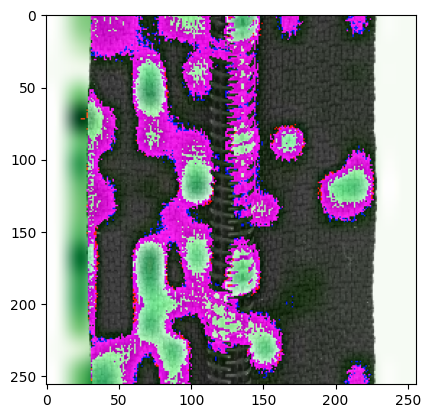

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [25]:
save_and_display_gradcam(image, heatmap1)
# image = image.cpu().numpy()
# mask = mask.cpu().numpy()